## Set up

## Load Dataset

In [2]:
import pandas as pd
data = pd.read_csv(r'../resources/processed_data.csv')

In [3]:
print(data.head())
data.shape

                                    Processed_Review sentiment
0  one review mention watch oz episod hook right ...  positive
1  wonder littl product film techniqu unassum old...  positive
2  thought wonder way spend time hot summer weeke...  positive
3  basic famili littl boy jake think zombi closet...  negative
4  petter mattei love time money visual stun film...  positive


(49582, 2)

### TFIDF

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Chuyển dữ liệu sang đặc trưng số sử dụng TF-IDF
tfidf = TfidfVectorizer(max_features=10000) 

# Chia data thành các tập train và test
X = tfidf.fit_transform(data['Processed_Review']).toarray()
# Chuyển sentiment positive thành 1 và negative thành 0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['sentiment'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train.shape

(34707, 10000)

## Multi-layer Perceptron

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Hàm tạo mô hình MLP
def create_mlp_model(input_dim, num_layers=1, num_neurons=128):
    model = Sequential()
    model.add(Dense(num_neurons, activation='relu', input_dim=input_dim, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    for _ in range(num_layers - 1):  
        model.add(Dense(num_neurons, activation='relu', kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))  
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrapper cho mô hình Keras
class KerasMLPWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, num_layers=1, num_neurons=128, batch_size=128, epochs=15):
        self.input_dim = input_dim
        self.num_layers = num_layers
        self.num_neurons = num_neurons
        self.batch_size = batch_size
        self.epochs = epochs

    def fit(self, X, y):
        self.model = create_mlp_model(self.input_dim, self.num_layers, self.num_neurons)
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
        self.history = self.model.fit(
            X, y, 
            batch_size=self.batch_size, 
            epochs=self.epochs, 
            validation_split=0.2, 
            callbacks=[early_stopping],
            verbose=1
        )
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def score(self, X, y):
        return self.model.evaluate(X, y, verbose=0)[1]  

# Cài đặt GridSearchCV với wrapper Keras
grid_params = {
    'num_layers': [1, 3, 5],  
    'num_neurons': [128, 256]  
}


# Chạy GridSearch trên tập train
model = KerasMLPWrapper(input_dim=X_train.shape[1])
grid_search = GridSearchCV(estimator=model, param_grid=grid_params, cv=3, n_jobs=1, verbose=1)
grid_search_result = grid_search.fit(X_train, y_train)

# In kết quả tốt nhất
print(f"Best parameters: {grid_search_result.best_params_}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7992 - loss: 0.5577 - val_accuracy: 0.8187 - val_loss: 0.7356
Epoch 2/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9430 - loss: 0.2905 - val_accuracy: 0.8695 - val_loss: 0.6322
Epoch 3/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9667 - loss: 0.2334 - val_accuracy: 0.8647 - val_loss: 0.5097
Epoch 4/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9760 - loss: 0.2107 - val_accuracy: 0.8632 - val_loss: 0.4680
Epoch 5/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9797 - loss: 0.2062 - val_accuracy: 0.8580 - val_loss: 0.5180
Epoch 6/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9818 - loss: 0.2066 - val_accuracy: 0.8615 - val_loss: 0.5595
Epoch 7/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9853 - loss: 0.1977 - val_accuracy: 0.8619 - val_loss: 0.5803
Epoch 7: early stopping
Epoch 1/15
145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8104 -

465/465 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      7461
           1       0.86      0.89      0.87      7414

    accuracy                           0.87     14875
   macro avg       0.87      0.87      0.87     14875
weighted avg       0.87      0.87      0.87     14875

Test Accuracy: 0.8723


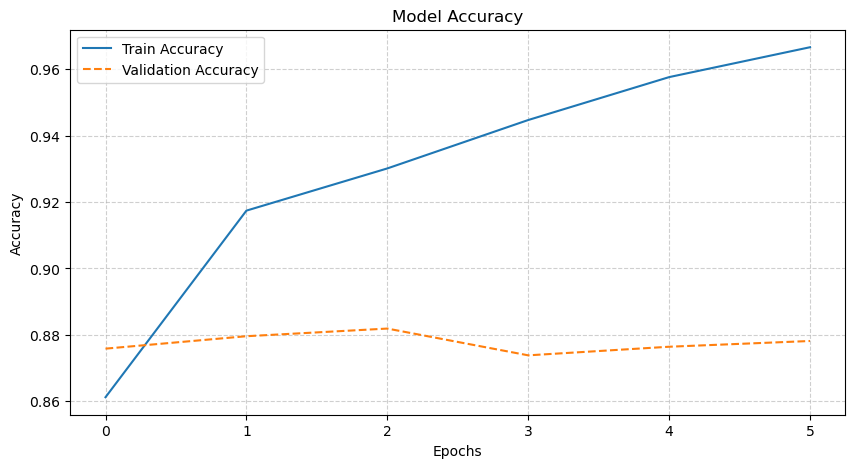

<Figure size 800x600 with 0 Axes>

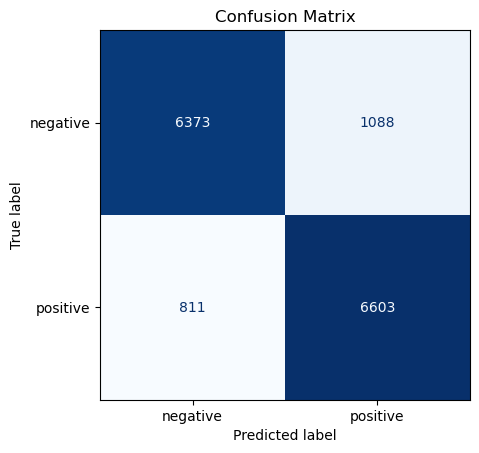

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Đánh giá mô hình tốt nhất trên tập test
best_model = grid_search_result.best_estimator_
y_pred = best_model.predict(X_test)

# Báo cáo phân loại và độ chính xác
print("Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Vẽ Biểu Đồ Độ Chính Xác
history = best_model.history

# Biểu đồ Độ Chính Xác
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()  # Hiển thị biểu đồ độ chính xác

# Vẽ Ma Trận Nhầm Lẫn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', colorbar=False)
plt.title('Confusion Matrix')
plt.show()  # Hiển thị ma trận nhầm lẫn


### Word2Vec

- MLP

In [115]:
import pickle 
with open("../resources/X_w2v_train.pkl", "rb") as f:
    X_w2v_train = pickle.load(f)
with open("../resources/X_w2v_test.pkl", "rb") as f:
    X_w2v_test = pickle.load(f)
with open("../resources/y_train.pkl", "rb") as f:
    y_w2v_train = pickle.load(f)
with open("../resources/y_test.pkl", "rb") as f:
    y_w2v_test = pickle.load(f)

In [116]:
y_w2v_train.shape

(35000,)

In [117]:
print(y_w2v_train[:5])

38094    negative
40624    positive
49425    negative
35734    positive
41708    negative
Name: sentiment, dtype: object


In [118]:
import numpy as np

X_w2v_train = np.array(X_w2v_train)
X_w2v_test = np.array(X_w2v_test)

X_w2v_train.shape

(35000, 400)

In [119]:
import numpy as np

y_w2v_train = [1 if label == 'positive' else 0 for label in y_w2v_train]
y_w2v_test = [1 if label == 'positive' else 0 for label in y_w2v_test]

y_w2v_train = np.array(y_w2v_train)
y_w2v_test = np.array(y_w2v_test)


In [123]:
print(y_w2v_test)

[1 1 0 ... 0 1 1]


In [131]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Hàm tạo mô hình MLP
def create_mlp_model(input_dim, num_layers=1, num_neurons=128):
    model = Sequential()
    model.add(Dense(num_neurons, activation='relu', input_dim=input_dim, kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    for _ in range(num_layers - 1):  
        model.add(Dense(num_neurons, activation='relu', kernel_regularizer=l2(0.001)))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))

    model.add(Dense(1, activation='sigmoid'))  
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrapper cho mô hình Keras
class KerasMLPWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, num_layers=1, num_neurons=128, batch_size=128, epochs=20):
        self.input_dim = input_dim
        self.num_layers = num_layers
        self.num_neurons = num_neurons
        self.batch_size = batch_size
        self.epochs = epochs

    def fit(self, X, y):
        self.model = create_mlp_model(self.input_dim, self.num_layers, self.num_neurons)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
        self.history = self.model.fit(
            X, y, 
            batch_size=self.batch_size, 
            epochs=self.epochs, 
            validation_split=0.2, 
            callbacks=[early_stopping],
            verbose=1
        )
        return self

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def score(self, X, y):
        return self.model.evaluate(X, y, verbose=0)[1]  

# Cài đặt GridSearchCV với wrapper Keras
grid_params = {
    'num_layers': [1, 3, 5],  
    'num_neurons': [128, 256]  
}

# Chạy GridSearch trên tập train
model = KerasMLPWrapper(input_dim=X_w2v_train.shape[1])
grid_search = GridSearchCV(estimator=model, param_grid=grid_params, cv=3, n_jobs=1, verbose=1)
grid_search_result = grid_search.fit(X_w2v_train, y_w2v_train)

# In kết quả tốt nhất
print(f"Best parameters: {grid_search_result.best_params_}")


Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8180 - loss: 0.5516 - val_accuracy: 0.8346 - val_loss: 0.6593
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8809 - loss: 0.3941 - val_accuracy: 0.8762 - val_loss: 0.5160
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8885 - loss: 0.3587 - val_accuracy: 0.8815 - val_loss: 0.4092
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8836 - loss: 0.3436 - val_accuracy: 0.8815 - val_loss: 0.3437
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8849 - loss: 0.3306 - val_accuracy: 0.8804 - val_loss: 0.3198
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8885 - loss: 0.3160 - val_accuracy: 0.8894 - val_loss: 0.3018
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8861 - loss: 0.3101 - val_accuracy: 0.8830 - val_loss: 0.3131
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8862 - loss: 0.3079 - val_accuracy: 0.

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      7411
           1       0.89      0.89      0.89      7589

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000

Test Accuracy: 0.8902


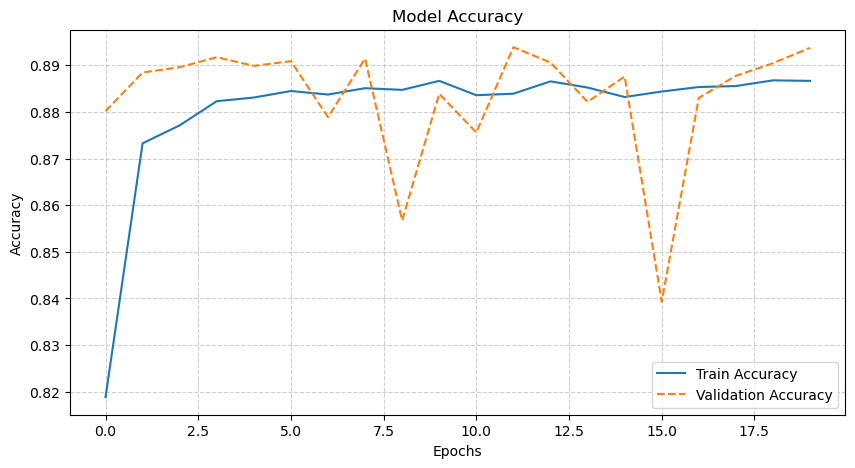

<Figure size 800x600 with 0 Axes>

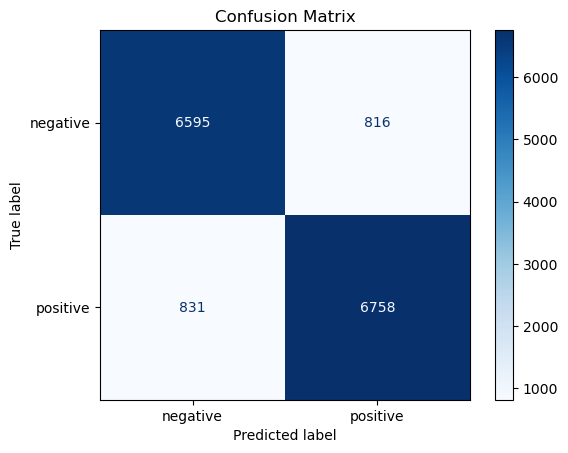

In [132]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Đánh giá mô hình tốt nhất trên tập test
best_model = grid_search_result.best_estimator_
y_w2v_pred = best_model.predict(X_w2v_test)

# Báo cáo phân loại và độ chính xác
print("Classification Report:")
print(classification_report(y_w2v_test, y_w2v_pred))

accuracy = accuracy_score(y_w2v_test, y_w2v_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Vẽ Biểu Đồ Độ Chính Xác
history = best_model.history

# Biểu đồ Độ Chính Xác
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()  # Hiển thị biểu đồ độ chính xác


# Vẽ Ma Trận Nhầm Lẫn
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_w2v_test, y_w2v_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"])
disp.plot(cmap='Blues', colorbar=True)
plt.title('Confusion Matrix')
plt.show()
